In [1]:
import glob
import os
import sys
import time as time_module


import numpy as np
import pandas as pd
from mvgavg import mvgavg
import skimage
import importlib
import matplotlib.pyplot as plt
%matplotlib widget

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tools

PAMFluo_path = "C:/Users/Lab/Desktop/DREAM_repo/Codes_Alienor/PAMFluo-dynamic_python"
if PAMFluo_path not in sys.path:
    sys.path.append(PAMFluo_path)

import VoltageIntensityClass


In [2]:
######## Set the path to experimental and processed data ########

path = "E:/Experimental_data/DREAM_microscope/"
exp = "2024-01-29_17_08_low_intensity_DCM_calib_cam/"
folder = path + exp
data_processing_folder = folder + "data_processing/"
if not os.path.exists(data_processing_folder):
    os.mkdir(data_processing_folder)


In [3]:
######## Load photodiode outputs ########

list_photodiode_output = sorted(glob.glob(folder + "*output*"), key=os.path.getmtime)
outputs_photodiode = []
for i in list_photodiode_output:
    outputs_photodiode.append(pd.read_csv(i))

In [7]:
# Subtract baseline from photodiode outputs

for i, output in enumerate(outputs_photodiode):
    output["Fluo"] = output["Fluo"] - np.mean(output["Fluo"][0:tools.closest_index(output["time"], 1)])

C:\Users\Lab\AppData\Local\Temp\ipykernel_7532\1084332161.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


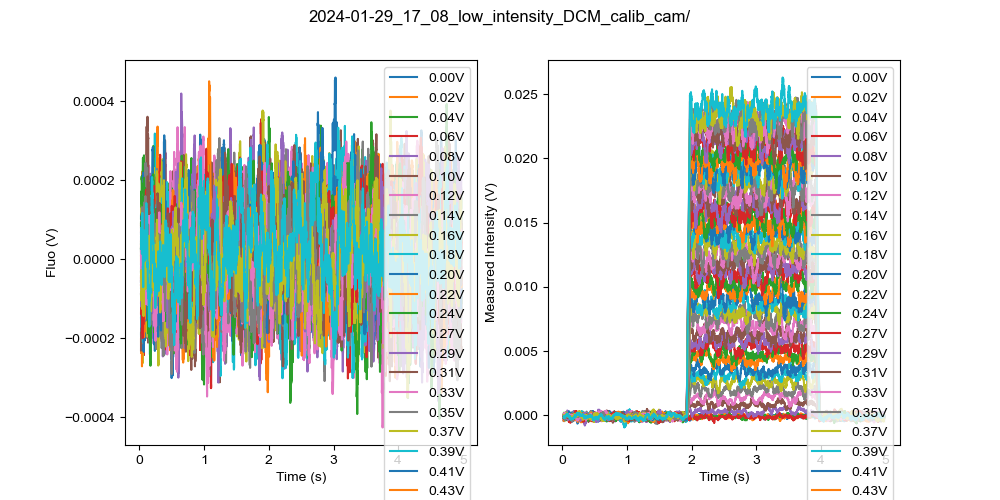

In [8]:
# Plot photodiode outputs

# "time" : time in seconds
# "Intensity" : measured intensity in V
# "Fluo" : intensity measured by the MPPC/only noise if mirror is closed
# "Blue" : set intensity for blue LED in V
# "Purple" : set intensity for purple LED in V
# "Green" : set intensity for green LED in V
# "Trigger" : trigger signal for the camera
# "jspq" : unknown

avg = 50
fig, ax = plt.subplots(1,2, figsize = (10,5))
fig.suptitle(exp)
for i, output in enumerate(outputs_photodiode):
    x = mvgavg(output["time"], avg)
    y = mvgavg(output["Fluo"], avg)
    y2 = mvgavg(output["Intensity"], avg)
    ax[0].plot(x, y, '-', label= list_photodiode_output[i].split("\\")[-1].split("_")[-1].split(".csv")[0], color = f"C{i}")
    ax[1].plot(x, y2, '-', label= list_photodiode_output[i].split("\\")[-1].split("_")[-1].split(".csv")[0], color = f"C{i}")
    ax[0].set_xlabel("Time (s)")
    ax[1].set_xlabel("Time (s)")
    ax[0].set_ylabel("Fluo (V)")
    ax[1].set_ylabel("Measured Intensity (V)")
    #ax.plot(x, y2, color = f"C{i}")

ax[0].legend()
ax[1].legend()
fig.tight_layout()
fig.savefig(data_processing_folder + "photodiode_outputs.png", dpi=300)


In [9]:
######## Get the measured intensities ########

Actinic_measured_volt = []
F_stat_MPPC = []

for i in range(len(outputs_photodiode)):
    Actinic_measured_volt.append(np.mean(outputs_photodiode[i][tools.closest_index(outputs_photodiode[i]["time"], 2.01):tools.closest_index(outputs_photodiode[i]["time"], 3.99)]["Intensity"])*100)
    F_stat_MPPC.append(np.mean(outputs_photodiode[i][tools.closest_index(outputs_photodiode[i]["time"], 2.01):tools.closest_index(outputs_photodiode[i]["time"], 3.99)]["Fluo"]))

    
Actinic_set_volt = np.linspace(0, 1, 50)


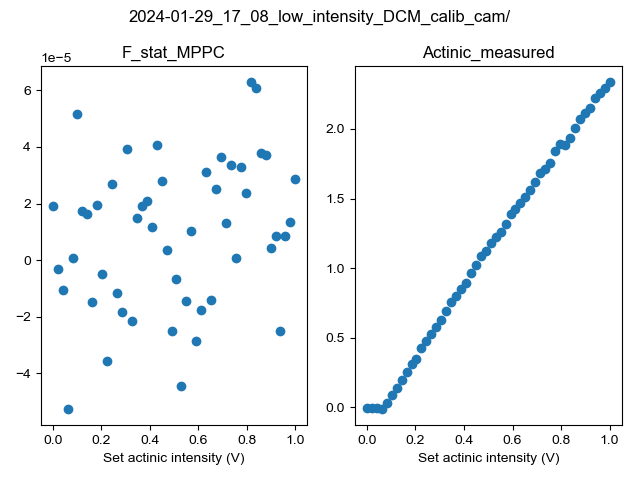

In [11]:
fig, ax = plt.subplots(1,2)
fig.suptitle(exp)
ax = ax.flatten()

ax[0].plot(Actinic_set_volt, F_stat_MPPC, 'o')
ax[1].plot(Actinic_set_volt, Actinic_measured_volt, 'o')
[ax.set_xlabel("Set actinic intensity (V)") for ax in ax]
ax[0].set_title("F_stat_MPPC")
ax[1].set_title("Actinic_measured")
fig.tight_layout()

fig.savefig(data_processing_folder + "MPPC_measurements.png", dpi=300)

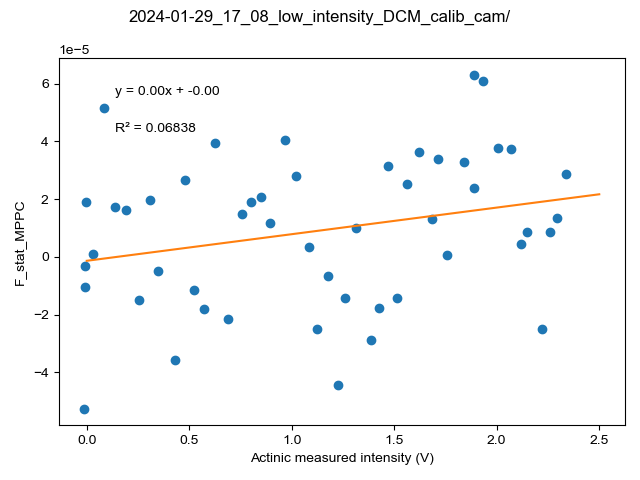

In [14]:
fig, ax = plt.subplots()
fig.suptitle(exp)
ax.plot(Actinic_measured_volt, F_stat_MPPC, 'o')
popt, x_fit, y_fit, r_sq = tools.lin_fit(Actinic_measured_volt, F_stat_MPPC, 0,2.5, 10)
ax.plot(x_fit, y_fit, label = "lin reg")
ax.text(0.1, 0.8, f"R² = {r_sq:.5f}", transform=ax.transAxes)
ax.text(0.1, 0.9, f"y = {popt[0]:.2f}x + {popt[1]:.2f}", transform=ax.transAxes)
ax.set_xlabel("Actinic measured intensity (V)")
ax.set_ylabel("F_stat_MPPC")
fig.tight_layout()
fig.savefig(data_processing_folder + "F_stat_MPPC_vs_actinic_measured.png", dpi=300)

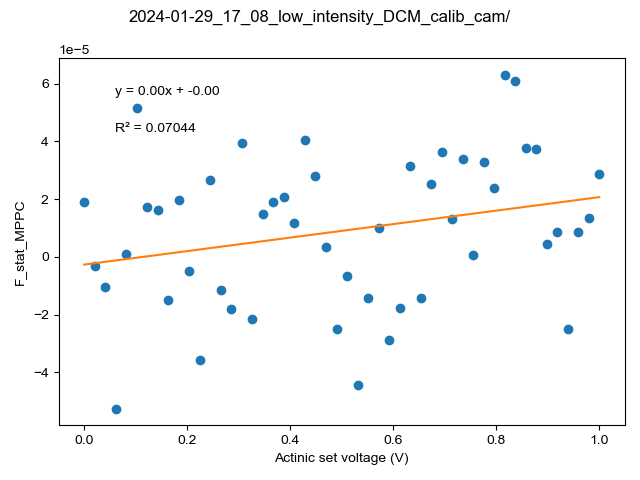

In [16]:
fig, ax = plt.subplots()
fig.suptitle(exp)
ax.plot(Actinic_set_volt, F_stat_MPPC, 'o')
popt, x_fit, y_fit, r_sq = tools.lin_fit(Actinic_set_volt, F_stat_MPPC, 0,1, 10)
ax.plot(x_fit, y_fit, label = "lin reg")
ax.text(0.1, 0.8, f"R² = {r_sq:.5f}", transform=ax.transAxes)
ax.text(0.1, 0.9, f"y = {popt[0]:.2f}x + {popt[1]:.2f}", transform=ax.transAxes)
ax.set_xlabel("Actinic set voltage (V)")
ax.set_ylabel("F_stat_MPPC")
fig.tight_layout()
fig.savefig(data_processing_folder + "F_stat_MPPC_vs_actinic_set.png", dpi=300)

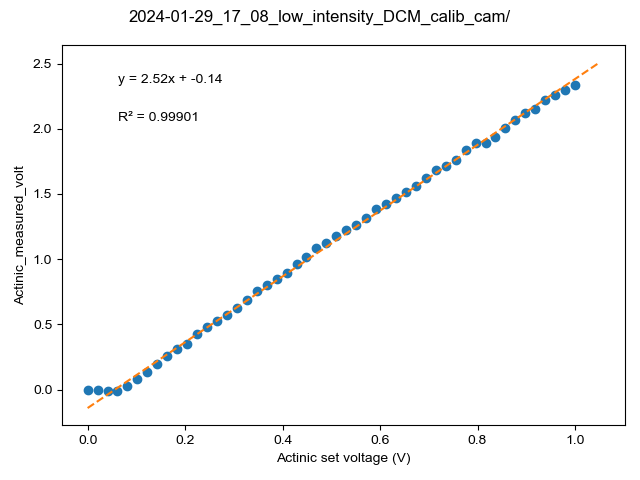

In [26]:
fig, ax = plt.subplots()
fig.suptitle(exp)
ax.plot(Actinic_set_volt, Actinic_measured_volt, 'o')
popt, x_fit, y_fit, r_sq = tools.lin_fit(Actinic_set_volt[3:], Actinic_measured_volt[3:], 0,1.05, 10)
ax.plot(x_fit, y_fit, '--', label = "lin reg")
ax.text(0.1, 0.8, f"R² = {r_sq:.5f}", transform=ax.transAxes)
ax.text(0.1, 0.9, f"y = {popt[0]:.2f}x + {popt[1]:.2f}", transform=ax.transAxes)
ax.set_xlabel("Actinic set voltage (V)")
ax.set_ylabel("Actinic_measured_volt")
fig.tight_layout()
fig.savefig(data_processing_folder + "Actinic_measured_volt.png", dpi=300)

In [27]:
######## Load videos ########

loading_time = time_module.time()

video_times = []
videos = []

for file in sorted(glob.glob(folder + "*video_timing*"), key=os.path.getmtime):
    video_times.append(np.load(file))

for file in sorted(glob.glob(folder + "*video.tiff"), key=os.path.getmtime):
    #videos.append(skimage.io.imread(file)[:,400:500, 400:500])
    videos.append(skimage.io.imread(file))

videos = np.asarray(videos)    

N = videos.shape[0] # number of videos
T = videos.shape[1] # number of frames
H = videos.shape[2] # height if image in pixels
W = videos.shape[3] # width of image in pixels


loading_time = time_module.time() - loading_time
print("Loading time = " + str(loading_time) + "s")


Loading time = 0.33315539360046387s


C:\Users\Lab\AppData\Local\Temp\ipykernel_7532\2967345142.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


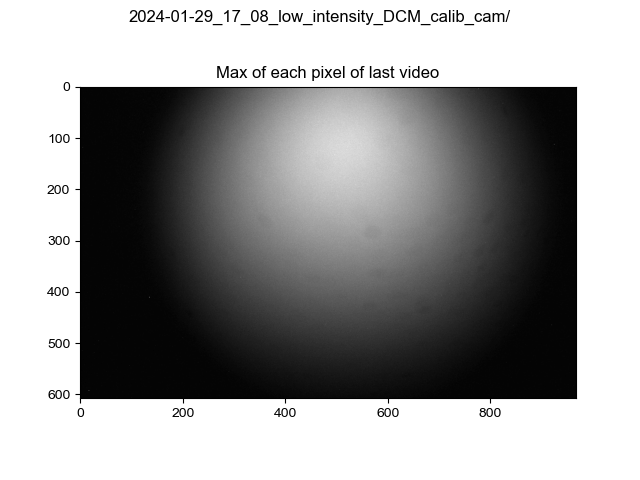

In [28]:
fig, ax = plt.subplots()
fig.suptitle(exp)
ax.imshow(np.max(videos[-1][:], axis = 0), cmap = "gray")
ax.set_title("Max of each pixel of last video")

fig.savefig(data_processing_folder + "max_of_last_video.png", dpi=300)

In [29]:
mask = np.ones((H,W), dtype=bool)

In [30]:
######### Use mask to compute single cell dynamics ########

if True:
    frame_rate = 15 # frame rate of the camera in Hz
   
    from tqdm import tqdm

    nb_cell = np.max(mask.astype(int))

    Cell = np.zeros([nb_cell,N,T])
    Cell_std = np.zeros([nb_cell,N,T])

    for k in tqdm(range(nb_cell)):
        Intensity = np.zeros([N,T])
        Intensity_std = np.zeros([N,T])
        for i in range(N):
            fluo = np.zeros(T)
            fluo_std =  np.zeros(T)
            for j in range(T):        
                fluo[j] = np.mean(videos[i][j][mask])
                fluo_std[j] = np.std(videos[i][j][mask])
            Intensity[i][:] = fluo
            Intensity_std[i][:] = fluo_std
        Cell[k][:][:] = Intensity
        Cell_std[k][:][:] = Intensity_std
    
    np.save(data_processing_folder + "/Single_cell_dynamics.npy", Cell)
    np.save(data_processing_folder + "/Single_cell_dynamics_std.npy", Cell_std)

Cell = np.load(data_processing_folder + "/Single_cell_dynamics.npy")
Cell_std = np.load(data_processing_folder + "/Single_cell_dynamics_std.npy")


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


In [32]:
Cell.shape

(1, 50, 30)

C:\Users\Lab\AppData\Local\Temp\ipykernel_7532\929408292.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


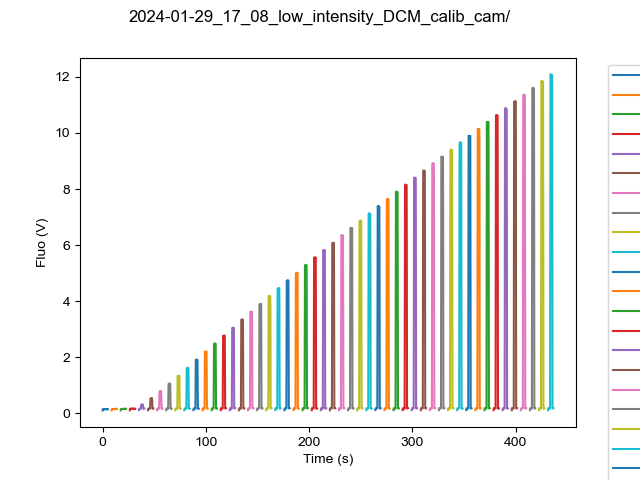

In [33]:
######### Plot fluo dynamics ########

nb_cell = len(Cell)
nb_video = len(Cell[0])
frames = len(Cell[0][0])
F_stat_cam = []
F_max_cam = []

fig = plt.figure()
fig.suptitle(exp)
ax = plt.gca()
for i in range(nb_video):
        ax.plot(video_times[i] - video_times[0][0],Cell[0][i], label= list_photodiode_output[i].split("\\")[-1].split("_")[-1].split(".csv")[0], color = f"C{i}")



ax.set_xlabel("Time (s)")
ax.set_ylabel("Fluo (V)")
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout()
fig.savefig(data_processing_folder + "fluo_cam_dynamics.png", dpi=300)

In [34]:
F_stat_cam = []
for i in range(nb_video):
        x = video_times[i] - video_times[i][0]
        y = Cell[0][i]
        F_stat_cam.append(np.mean(y[tools.closest_index(x, 2.1):tools.closest_index(x, 3.9)]))

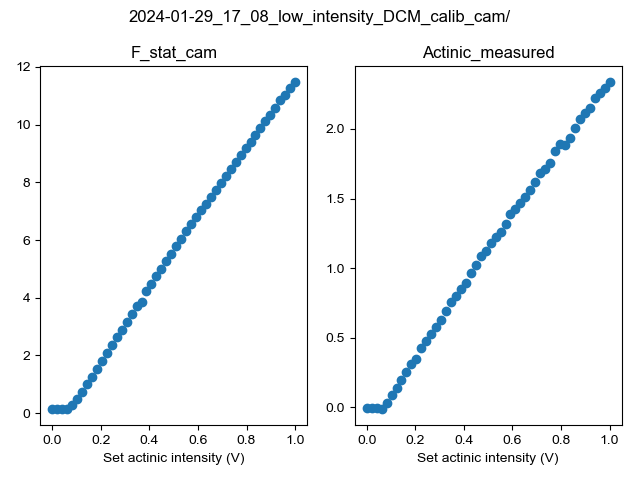

In [36]:
fig, ax = plt.subplots(1,2)
fig.suptitle(exp)
ax = ax.flatten()

ax[0].plot(Actinic_set_volt, F_stat_cam, 'o')
ax[1].plot(Actinic_set_volt, Actinic_measured_volt, 'o')
[ax.set_xlabel("Set actinic intensity (V)") for ax in ax]
ax[0].set_title("F_stat_cam")
ax[1].set_title("Actinic_measured")
fig.tight_layout()

fig.savefig(data_processing_folder + "cam_measurements.png", dpi=300)

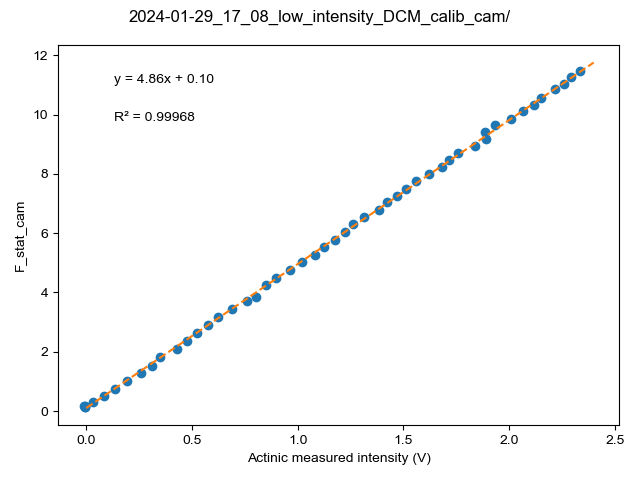

In [39]:
fig, ax = plt.subplots()
fig.suptitle(exp)
ax.plot(Actinic_measured_volt, F_stat_cam, 'o')
popt, x_fit, y_fit, r_sq = tools.lin_fit(Actinic_measured_volt, F_stat_cam, 0,2.4, 10)
ax.plot(x_fit, y_fit, '--', label = "lin reg")
ax.text(0.1, 0.8, f"R² = {r_sq:.5f}", transform=ax.transAxes)
ax.text(0.1, 0.9, f"y = {popt[0]:.2f}x + {popt[1]:.2f}", transform=ax.transAxes)
ax.set_xlabel("Actinic measured intensity (V)")
ax.set_ylabel("F_stat_cam")
fig.tight_layout()
fig.savefig(data_processing_folder + "F_stat_cam_vs_actinic_measured.png", dpi=300)

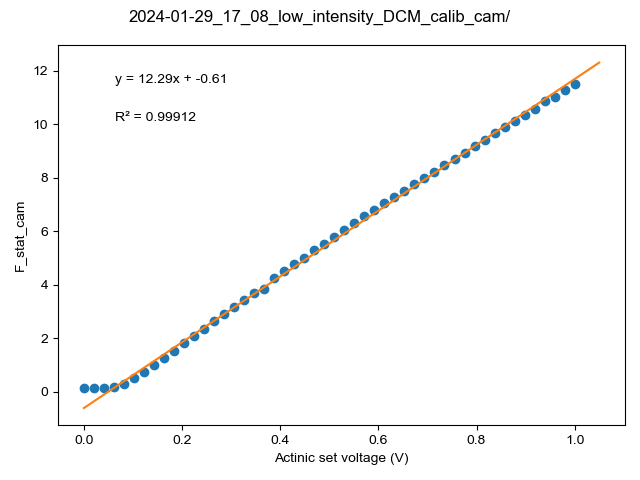

In [41]:
fig, ax = plt.subplots()
fig.suptitle(exp)
ax.plot(Actinic_set_volt, F_stat_cam, 'o')
popt, x_fit, y_fit, r_sq = tools.lin_fit(Actinic_set_volt[4:], F_stat_cam[4:], 0,1.05, 10)
ax.plot(x_fit, y_fit, label = "lin reg")
ax.text(0.1, 0.8, f"R² = {r_sq:.5f}", transform=ax.transAxes)
ax.text(0.1, 0.9, f"y = {popt[0]:.2f}x + {popt[1]:.2f}", transform=ax.transAxes)
ax.set_xlabel("Actinic set voltage (V)")
ax.set_ylabel("F_stat_cam")
fig.tight_layout()
fig.savefig(data_processing_folder + "F_stat_cam_vs_actinic_set.png", dpi=300)